In [8]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf
from scipy.stats import boxcox

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
data_file = DATA_PATH + "EPM_test_dict_May_17.pkl"
proj_file = PROJECT_PATH + "EPM_Holdout_boxcox_Projections.csv"
mean_file = PROJECT_PATH + "EPM_Holdout_boxcox_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]



import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list

In [4]:
with open(data_file,"rb") as f:
    epm_test_dict = pickle.load(f)

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)
epm_y_expDate_test = epm_test_dict['y_expDate']

In [5]:
np.unique(epm_test_dict['y_vel'][y_in_task_mask_test==0])

array([-2147483648], dtype=int32)

In [6]:
np.unique(y_mouse_test,return_counts=True)

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
        'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'),
 array([343, 633, 649, 630, 582, 593, 750, 672, 638, 619, 705]))

In [7]:
epm_test_auc = model.score(X_test,
                          y_in_task_mask_test.reshape(-1,1),
                          y_mouse_test,
                          return_dict=True)

epm_mean_test_auc = np.mean([epm_test_auc[key] for key in epm_test_auc.keys()])
epm_stderr_test_auc = np.std([epm_test_auc[key] for key in epm_test_auc.keys()]) / np.sqrt(len(epm_test_auc.keys()))

print("EPM test auc: {:.3f} +/- {:.3f}".format(epm_mean_test_auc,epm_stderr_test_auc))
print(epm_test_auc)

EPM test auc: 0.756 +/- 0.027
{'Mouse0641': [0.7422324510932107], 'Mouse39115': [0.891685935457927], 'Mouse39121': [0.906627367939106], 'Mouse39122': [0.7198150541108062], 'Mouse39132': [0.6635451110061408], 'Mouse39135': [0.871639430680021], 'Mouse6674': [0.6546029776674938], 'Mouse69061': [0.7085181384141715], 'Mouse69071': [0.7389144033573523], 'Mouse69075': [0.7610080628315996], 'Mouse8893': [0.6597929274098717]}


In [10]:
s_epm_test = model.project(X_test)
auc_epm_test = [epm_test_auc[mouse][0] for mouse in y_mouse_test]
auc_epm_test_3_net = get_3_net_auc_dict(s_epm_test,
                                        y_in_task_mask_test,
                                        y_mouse_test)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
agg_score = s_epm_test[:,:3] @ coeffs
proj_dict = {
    "agg score":boxcox(agg_score)[0],
    "net 1 scores":boxcox(s_epm_test[:,0])[0],
    "net 2 scores":boxcox(s_epm_test[:,1])[0],
    "net 3 scores":boxcox(s_epm_test[:,2])[0],
    "in-task":y_in_task_mask_test,
    "mouse":y_mouse_test,
    "time":y_time_test,
    "expDate":epm_y_expDate_test,
    "auc (Homecage vs. Task)":auc_epm_test,
    "net 1 auc (Homecage vs. Task)":[auc_epm_test_3_net[0][mouse][0] for mouse in y_mouse_test],
    "net 2 auc (Homecage vs. Task)":[auc_epm_test_3_net[1][mouse][0] for mouse in y_mouse_test],
    "net 3 auc (Homecage vs. Task)":[auc_epm_test_3_net[2][mouse][0] for mouse in y_mouse_test],
    "roi":epm_test_dict["y_ROI"],
    "velocity":epm_test_dict["y_vel"],
    
}

df_proj = pd.DataFrame.from_dict(proj_dict)
df_proj.to_csv(proj_file)
df_proj.head()

,agg score,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,1.237659,-1.093737,-1.183019,-1.365235,False,Mouse0641,1,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
1,0.670514,-1.126103,-1.251175,-1.413384,False,Mouse0641,2,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
2,1.343043,-1.089399,-1.170490,-1.316772,False,Mouse0641,4,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
3,2.432935,-1.016129,-1.044513,-1.473088,False,Mouse0641,12,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
4,1.504922,-1.109150,-1.124459,-1.579910,False,Mouse0641,13,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648


In [11]:
mouse_roi_comp_net_OA_dict = {}
mouse_roi_1_net_OA_dict = {}
mouse_roi_2_net_OA_dict = {}
mouse_roi_3_net_OA_dict = {}

mouse_roi_comp_net_CA_dict = {}
mouse_roi_1_net_CA_dict = {}
mouse_roi_2_net_CA_dict = {}
mouse_roi_3_net_CA_dict = {}

for mouse in np.unique(df_proj["mouse"]):
    task_mouse_mask = np.logical_and(df_proj["in-task"]==1,df_proj["mouse"]==mouse)
    
    comp_score_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["agg score"])
    net_1_scores_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["net 1 scores"])
    net_2_scores_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["net 2 scores"])
    net_3_scores_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["net 3 scores"])
    
    mouse_roi_comp_net_OA_dict[mouse] = comp_score_mean_OA
    mouse_roi_1_net_OA_dict[mouse] = net_1_scores_mean_OA
    mouse_roi_2_net_OA_dict[mouse] = net_2_scores_mean_OA
    mouse_roi_3_net_OA_dict[mouse] = net_3_scores_mean_OA
    
    comp_score_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["agg score"])
    net_1_scores_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["net 1 scores"])
    net_2_scores_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["net 2 scores"])
    net_3_scores_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["net 3 scores"])
    
    mouse_roi_comp_net_CA_dict[mouse] = comp_score_mean_CA
    mouse_roi_1_net_CA_dict[mouse] = net_1_scores_mean_CA
    mouse_roi_2_net_CA_dict[mouse] = net_2_scores_mean_CA
    mouse_roi_3_net_CA_dict[mouse] = net_3_scores_mean_CA

In [14]:
def boxcox_matrix(A):
    transformed = []
    for column in range(A.shape[1]):
        transformed.append(boxcox(A[:,column])[0].reshape(-1,1))
    transformed = np.hstack(transformed)
    return transformed

s = model.project(X_test)
s = boxcox_matrix(s)

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [17]:
def boxcox_matrix(A):
    transformed = []
    for column in range(A.shape[1]):
        transformed.append(boxcox(A[:,column])[0].reshape(-1,1))
    transformed = np.hstack(transformed)
    return transformed

s = boxcox_matrix(model.project(X_test))
y_mouse = y_mouse_test
y_task = y_in_task_mask_test

#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
    task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
    
    avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
    avg_score_hc = np.mean(s[hc_mouse_mask==1,:3],axis=0)
    avg_score_task = np.mean(s[task_mouse_mask==1,:3],axis=0)
    
    mouse_list.append(mouse)
    avg_score_list.append(avg_score)
    avg_hc_score_list.append(avg_score_hc)
    avg_task_score_list.append(avg_score_task)
    
avg_score_list = np.array(avg_score_list)
avg_hc_score_list = np.array(avg_hc_score_list)
avg_task_score_list = np.array(avg_task_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_score_list = avg_score_list*coeffs
mag_hc_score_list = avg_hc_score_list*coeffs
mag_task_score_list = avg_task_score_list*coeffs

net_impact_scores = mag_score_list / np.sum(mag_score_list,axis=1).reshape(-1,1)
net_hc_scores = mag_hc_score_list / np.sum(mag_hc_score_list,axis=1).reshape(-1,1)
net_task_scores = mag_task_score_list / np.sum(mag_task_score_list,axis=1).reshape(-1,1)



proj_dict = {
    "mouse":mouse_list,
    "auc": [epm_test_auc[mouse][0] for mouse in mouse_list],
    
    "composite avgOAScore":[mouse_roi_comp_net_OA_dict[mouse] for mouse in mouse_list],
    "net 1 avgOAScore":[mouse_roi_1_net_OA_dict[mouse] for mouse in mouse_list],
    "net 2 avgOAScore":[mouse_roi_2_net_OA_dict[mouse] for mouse in mouse_list],
    "net 3 avgOAScore":[mouse_roi_3_net_OA_dict[mouse] for mouse in mouse_list],
    
    "composite avgCAScore":[mouse_roi_comp_net_CA_dict[mouse] for mouse in mouse_list],
    "net 1 avgCAScore":[mouse_roi_1_net_CA_dict[mouse] for mouse in mouse_list],
    "net 2 avgCAScore":[mouse_roi_2_net_CA_dict[mouse] for mouse in mouse_list],
    "net 3 avgCAScore":[mouse_roi_3_net_CA_dict[mouse] for mouse in mouse_list],
    
    "composite avgScore":np.sum(mag_score_list,axis=1),
    "net 1 avgScore":avg_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    
    "composite avgHCScore":np.sum(mag_hc_score_list,axis=1),
    "net 1 avgHCScore":avg_hc_score_list[:,0],
    "net 2 avgHCScore":avg_hc_score_list[:,1],
    "net 3 avgHCScore":avg_hc_score_list[:,2],
    
    "composite avgTaskScore":np.sum(mag_task_score_list,axis=1),
    "net 1 avgTaskScore":avg_task_score_list[:,0],
    "net 2 avgTaskScore":avg_task_score_list[:,1],
    "net 3 avgTaskScore":avg_task_score_list[:,2],
}
df_means = pd.DataFrame.from_dict(proj_dict)
df_means.to_csv(mean_file)
df_means.head()

,mouse,auc,composite avgOAScore,net 1 avgOAScore,net 2 avgOAScore,net 3 avgOAScore,composite avgCAScore,net 1 avgCAScore,net 2 avgCAScore,net 3 avgCAScore,...,net 2 avgScore,net 3 avgScore,composite avgHCScore,net 1 avgHCScore,net 2 avgHCScore,net 3 avgHCScore,composite avgTaskScore,net 1 avgTaskScore,net 2 avgTaskScore,net 3 avgTaskScore
0,Mouse0641,0.742232,2.204997,-1.051607,-1.058680,-1.438349,2.487691,-1.025982,-1.031615,-1.451612,...,-1.071125,-1.433500,-30.466814,-1.078575,-1.132582,-1.407557,-28.840555,-1.045978,-1.052734,-1.441263
1,Mouse39115,0.891686,2.334497,-1.054918,-1.033989,-1.576395,2.273951,-1.061561,-1.040104,-1.545460,...,-1.104172,-1.588423,-32.228302,-1.152266,-1.186275,-1.607235,-28.731468,-1.055751,-1.034755,-1.572517
2,Mouse39121,0.906627,2.536921,-0.989510,-1.046016,-1.628213,2.639740,-0.985017,-1.033136,-1.625756,...,-1.132745,-1.624466,-32.247841,-1.072409,-1.233779,-1.620566,-28.275335,-0.988900,-1.044267,-1.627880
3,Mouse39122,0.719815,2.997444,-1.113571,-0.901373,-1.597131,2.980456,-1.112685,-0.904031,-1.601714,...,-0.938427,-1.603424,-28.685959,-1.144884,-0.978074,-1.609225,-27.099699,-1.113387,-0.901924,-1.598081
4,Mouse39132,0.663545,2.572336,-1.099226,-0.970665,-1.607507,2.728889,-1.092104,-0.952617,-1.601726,...,-0.999949,-1.611529,-29.466299,-1.133713,-1.031134,-1.616197,-28.070036,-1.098391,-0.968549,-1.606830


### Statistical Testing

Wilcoxon Mean Open Arm Score vs Mean Closed Arm Score by Mouse:  0.0537109375


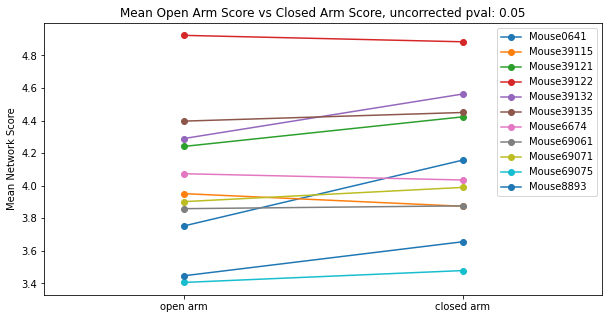

In [10]:
from scipy.stats import wilcoxon

s = model.project(X_test)
comp_s = np.sum(s[:,:3] * np.abs(model.classifier[0].weight[0].detach().cpu().numpy()),axis=1)

y_mouse = y_mouse_test
y_task = y_in_task_mask_test

mouse_list = []
open_arm_s = []
closed_arm_s = []
open_arm_t = []
closed_arm_t = []

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    
    mouse_obs_mask = np.logical_and(mouse_mask,test_nan_mask)
    mouse_obs_mask = np.logical_and(mouse_obs_mask,y_task==1)
    
    oa_obs_mask = np.logical_and(mouse_obs_mask,y_test)
    ca_obs_mask = np.logical_and(mouse_obs_mask,y_test==0)
        
    mean_oa_s = np.mean(comp_s[oa_obs_mask==1])
    mean_ca_s = np.mean(comp_s[ca_obs_mask==1])
    mean_oa_t = np.sum(oa_obs_mask)
    mean_ca_t = np.sum(ca_obs_mask)
    
    mouse_list.append(mouse)
    open_arm_s.append(mean_oa_s)
    closed_arm_s.append(mean_ca_s)
    open_arm_t.append(mean_oa_t)
    closed_arm_t.append(mean_ca_t)
    
results = wilcoxon(open_arm_s,closed_arm_s)
print("Wilcoxon Mean Open Arm Score vs Mean Closed Arm Score by Mouse: ",results.pvalue)

joined_scores = np.hstack((np.array(open_arm_s).reshape(-1,1),np.array(closed_arm_s).reshape(-1,1)))

plt.figure(figsize=(10,5))
for i, mouse in enumerate(mouse_list):
    plt.plot(joined_scores[i,:],"o-",label=mouse)
    
plt.xticks([0,1],["open arm","closed arm"])
plt.ylabel("Mean Network Score")
plt.xlim([-.5,1.5])
plt.legend()
plt.title("Mean Open Arm Score vs Closed Arm Score, uncorrected pval: {:.2f}".format(results.pvalue))
plt.savefig(FIGURE_PATH + "EPM OA vs CA Wilcox.svg")
plt.show()


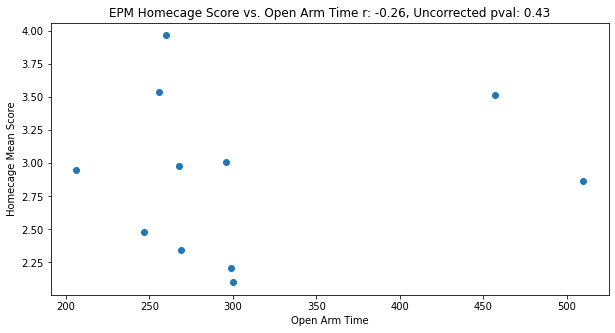

In [11]:
from scipy.stats import spearmanr

hc_mean_score = []
for i,mouse in enumerate(mouse_list):
    hc_mean_score.append(df_means[df_means["mouse"]==mouse]["composite avgHCScore"].to_numpy()[0])
    


stat,pval = spearmanr(open_arm_t,hc_mean_score)
plt.figure(figsize=(10,5))
plt.scatter(open_arm_t,hc_mean_score)
plt.xlabel("Open Arm Time")
plt.ylabel("Homecage Mean Score")
plt.title("EPM Homecage Score vs. Open Arm Time r: {:.2f}, Uncorrected pval: {:.2f}".format(stat,pval))
plt.savefig(FIGURE_PATH + "EPM Avg Score vs OA Time Spearman.svg")
plt.show()

In [1]:
open_arm_t

NameError: name 'open_arm_t' is not defined

In [12]:
df_proj

,agg score,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,2.412547,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.718930,0.735664,0.442271,1,-2147483648
1,1.725192,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.718930,0.735664,0.442271,1,-2147483648
2,2.546790,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
3,4.039915,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
4,2.756711,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6809,2.931020,0.086615,0.123805,0.025402,True,Mouse8893,755,111017,0.659793,0.592007,0.671710,0.413127,1,0
6810,3.068778,0.081682,0.134026,0.047029,True,Mouse8893,756,111017,0.659793,0.592007,0.671710,0.413127,1,0
6811,2.202641,0.074436,0.087170,0.027823,True,Mouse8893,758,111017,0.659793,0.592007,0.671710,0.413127,1,1
6812,2.688574,0.086926,0.108569,0.037213,True,Mouse8893,759,111017,0.659793,0.592007,0.671710,0.413127,1,1


## Entry Event Plots

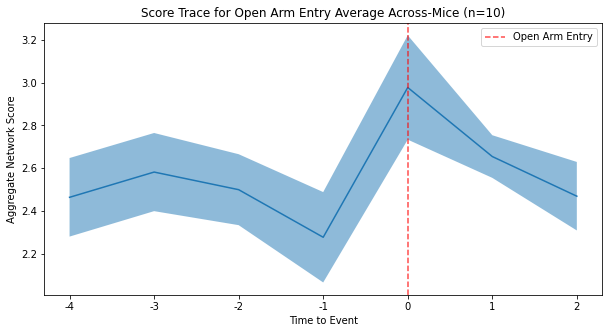

(33,)
(33, 7)


In [22]:
rois = df_proj["roi"].to_numpy()
scores = df_proj["agg score"].to_numpy()
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0

five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)

filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    
plt.figure(figsize=(10,5))
plt.plot(mean)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
#plt.ylim([3.2,5.5])
plt.legend()
plt.title("Score Trace for Open Arm Entry Average Across-Mice (n=10)")
#plt.savefig(FIGURE_PATH + "EPM CA to OA Entry Network Trace Across-Mice.svg")
plt.show()

print(mouse_final.shape)
print(scores_final.shape)

In [21]:
mean

array([2.4635494, 2.5817227, 2.499276 , 2.2765617, 2.9775329, 2.6543741,
       2.4687302], dtype=float32)

In [23]:
CA_to_OA_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final.astype(object)))
df = pd.DataFrame(CA_to_OA_data)
df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
df.to_csv(PROJECT_PATH + "EPM_Holdout_CA_to_OA_Entry_boxcox.csv")
df.head()

,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,1.30575,2.343305,2.756706,2.301714,2.446502,2.343517,2.075597
1,Mouse0641,3.11714,3.521404,2.635128,2.297638,3.169938,2.282508,1.369828
2,Mouse0641,3.70249,0.84233,2.610463,1.483964,2.627987,2.553297,1.741894
3,Mouse39115,3.577323,2.034465,3.392458,2.862736,4.177181,2.166899,3.383809
4,Mouse39121,2.7467,3.480923,1.852961,0.921138,2.701371,2.796792,2.578392


In [15]:
CA_to_OA_data.shape

(33, 8)

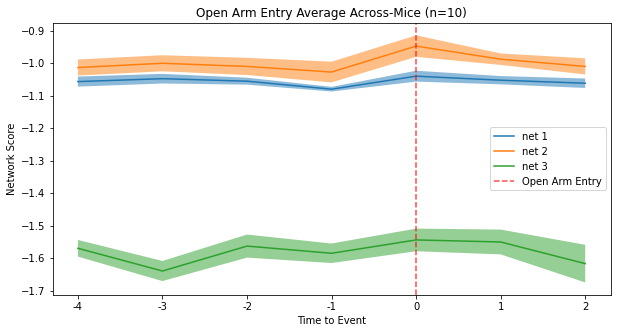

In [24]:
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

rois = df_proj["roi"].to_numpy()
scores = np.hstack((df_proj["net 1 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 2 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 3 scores"].to_numpy().reshape(-1,1)))
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0
five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)

filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]



scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])

plt.figure(figsize=(10,5))

for i in range(3):
    plt.plot(mean[:,i],label="net {}".format(i+1))
    plt.fill_between(range(7),mean[:,i]+stderr[:,i],mean[:,i]-stderr[:,i],alpha=0.5)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
#plt.ylim([0.02,0.25])
plt.ylabel("Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("Open Arm Entry Average Across-Mice (n={})".format((mouse_mean_scores.shape[0])))
plt.savefig(FIGURE_PATH + "boxcox EPM CA to OA Entry Individaul Network Trace Across-Mice.svg")
plt.show()

In [25]:
for i in range(3):
    CA_to_OA_net_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final[:,:,i].astype(object)))
    df = pd.DataFrame(CA_to_OA_net_data)
    df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
    df.to_csv(PROJECT_PATH + "EPM_Holdout_net_{}_CA_to_OA_Entry_boxcox.csv".format(i))
    print(df.shape)
df.head()

(33, 8)
(33, 8)
(33, 8)


,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,-1.444323,-1.617451,-1.679224,-1.686693,-1.455464,-1.296893,-1.480477
1,Mouse0641,-1.376423,-1.423923,-1.920212,-1.490845,-1.383098,-1.371133,-1.317743
2,Mouse0641,-1.48377,-1.464321,-1.512452,-1.431897,-1.285576,-1.306537,-1.526509
3,Mouse39115,-1.498222,-1.583999,-1.407707,-1.412725,-1.4139,-1.544814,-1.340726
4,Mouse39121,-1.73264,-1.845082,-1.495409,-1.626723,-1.783312,-1.532892,-1.792601


In [18]:
CA_to_OA_net_data.shape

(33, 8)

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
       'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
       'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'), array([3, 3, 2, 4, 1, 2, 8, 4, 1, 2, 2]))
(10, 7)


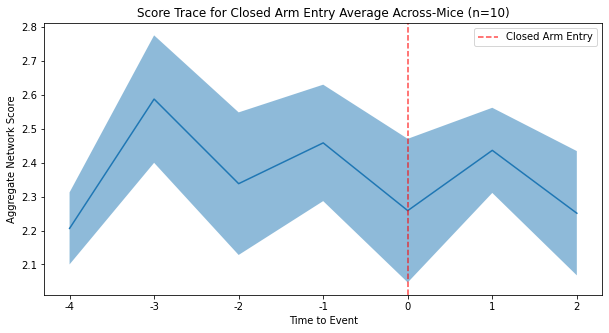

"\narray(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',\n        'Mouse39135', 'Mouse6674', 'Mouse69061', 'Mouse69071',\n        'Mouse69075', 'Mouse8893'], dtype='<U10'),\n        "

In [27]:
rois = df_proj["roi"].to_numpy()
agg_scores = df_proj["agg score"].to_numpy()
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0
five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)


scores = agg_scores
filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==0 and temp_rois[idx-1]==1:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 4
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 0
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    if mouse=="Mouse39132":
        continue
    else:
        mouse_mask = mouse_final==mouse
        mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
print(np.unique(mouse_final,return_counts=True))
print(mouse_mean_scores.shape)
plt.figure(figsize=(10,5))
plt.plot(mean)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Closed Arm Entry")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
#plt.ylim([3.2,5.5])
plt.legend()
plt.title("Score Trace for Closed Arm Entry Average Across-Mice (n={})".format(mouse_mean_scores.shape[0]))
plt.savefig(FIGURE_PATH + "boxcox EPM OA to CA Entry Network Trace Across-Mice.svg")
plt.show()

"""
array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39135', 'Mouse6674', 'Mouse69061', 'Mouse69071',
        'Mouse69075', 'Mouse8893'], dtype='<U10'),
        """

In [20]:
np.unique(mouse_final,return_counts=True)

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
        'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'),
 array([3, 3, 2, 4, 1, 2, 8, 4, 1, 2, 2]))

In [21]:
np.unique(mouse_final,return_counts=True)

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
        'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'),
 array([3, 3, 2, 4, 1, 2, 8, 4, 1, 2, 2]))

In [22]:
np.unique(mouse_final,return_counts=True)

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
        'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'),
 array([3, 3, 2, 4, 1, 2, 8, 4, 1, 2, 2]))

In [28]:
OA_to_CA_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final.astype(object)))
df = pd.DataFrame(OA_to_CA_data)
df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
df.to_csv(PROJECT_PATH + "EPM_Holdout_OA_to_CA_Entry_boxcox.csv")
print(df.shape)
df.head()

(32, 8)


,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,2.826163,2.50375,3.283654,1.377792,1.84601,1.571481,2.646607
1,Mouse0641,2.277038,2.652984,2.579365,1.972356,2.890347,2.509888,2.469768
2,Mouse0641,2.954285,2.273252,3.941904,3.400996,3.175274,3.081748,1.384956
3,Mouse39115,1.840453,2.7172,2.234093,1.931802,3.577323,2.034465,3.392458
4,Mouse39115,2.16821,2.344699,2.640765,1.758642,2.245347,2.869663,0.684188


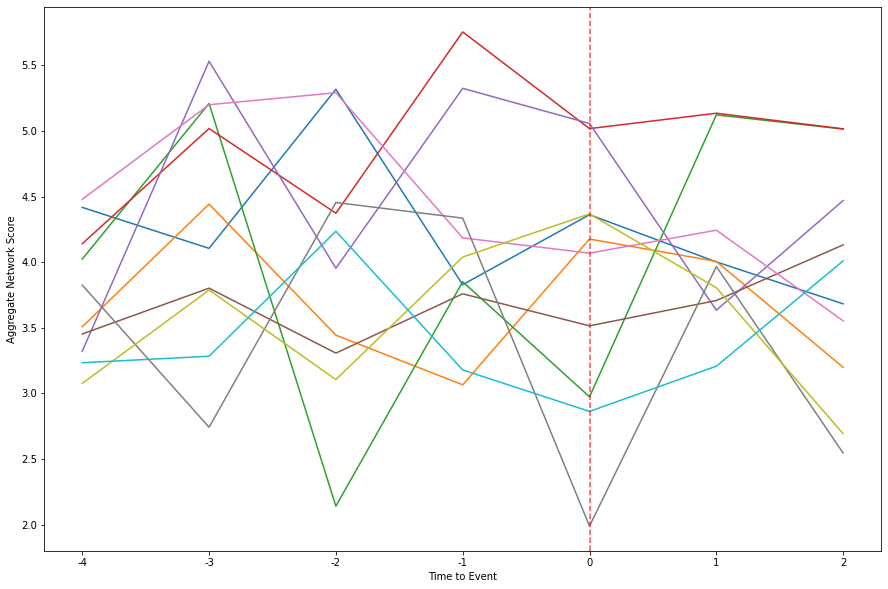

In [24]:
plt.figure(figsize=(15,10))
for mouse in mouse_mean_scores:
    plt.plot(range(7),mouse)
    

plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Closed Arm Entry")
plt.xticks(range(7), np.arange(7) - 4)
plt.show()

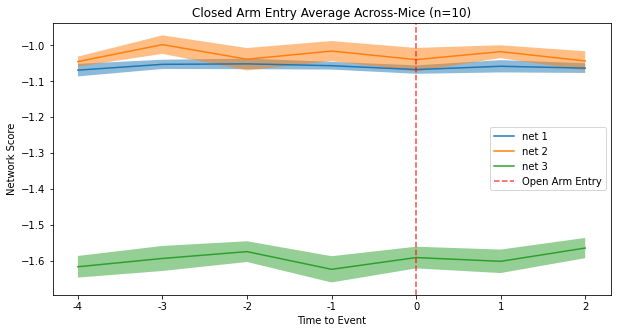

In [29]:
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

rois = df_proj["roi"].to_numpy()
scores = np.hstack((df_proj["net 1 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 2 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 3 scores"].to_numpy().reshape(-1,1)))
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0
five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)

filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []

for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==0 and temp_rois[idx-1]==1:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 4
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 0
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]



scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    if mouse=="Mouse39132":
        continue
    else:
        mouse_mask = mouse_final==mouse
        mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])

plt.figure(figsize=(10,5))

for i in range(3):
    plt.plot(mean[:,i],label="net {}".format(i+1))
    plt.fill_between(range(7),mean[:,i]+stderr[:,i],mean[:,i]-stderr[:,i],alpha=0.5)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.ylabel("Network Score")
plt.xlabel("Time to Event")
#plt.ylim([0.02,0.25])
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("Closed Arm Entry Average Across-Mice (n={})".format((mouse_mean_scores.shape[0])))
plt.savefig(FIGURE_PATH + "boxcox EPM OA to CA Entry Individual Network Trace Across-Mice.svg")
plt.show()

In [26]:
mouse_final

array(['Mouse0641', 'Mouse0641', 'Mouse0641', 'Mouse39115', 'Mouse39115',
       'Mouse39115', 'Mouse39121', 'Mouse39121', 'Mouse39122',
       'Mouse39122', 'Mouse39122', 'Mouse39122', 'Mouse39132',
       'Mouse39135', 'Mouse39135', 'Mouse6674', 'Mouse6674', 'Mouse6674',
       'Mouse6674', 'Mouse6674', 'Mouse6674', 'Mouse6674', 'Mouse6674',
       'Mouse69061', 'Mouse69061', 'Mouse69061', 'Mouse69061',
       'Mouse69071', 'Mouse69075', 'Mouse69075', 'Mouse8893', 'Mouse8893'],
      dtype='<U10')

In [30]:
for i in range(3):
    OA_to_CA_net_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final[:,:,i].astype(object)))
    df = pd.DataFrame(OA_to_CA_net_data)
    df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
    df.to_csv(PROJECT_PATH + "EPM_Holdout_net_{}_OA_to_CA_Entry_boxcox.csv".format(i))
    print(df.shape)
df.head()

(32, 8)
(32, 8)
(32, 8)


,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,-1.750297,-1.55286,-1.409525,-1.698097,-1.344588,-1.378396,-1.663061
1,Mouse0641,-1.314989,-1.327379,-1.399083,-1.595109,-1.514625,-1.415605,-1.550805
2,Mouse0641,-1.42981,-1.379519,-1.597075,-1.45648,-1.543702,-1.634028,-1.32144
3,Mouse39115,-1.648118,-1.484193,-1.504875,-1.411127,-1.498222,-1.583999,-1.407707
4,Mouse39115,-1.581857,-1.615953,-1.592427,-1.531459,-1.423224,-1.792771,-1.466382
